In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, cast, Date


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
base = automap_base()

# Use the Base class to reflect the database tables
base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
measurement = base.classes.measurement

station = base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

most_recent_date

('2017-08-23',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
starting_date = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d")


# Calculate the date one year from the last date in data set.
query_date = starting_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= (dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d")- dt.timedelta(days=366))).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(query, columns=['Date','Precipitation'])

# Sort the dataframe by date
prcp_df.sort_values(by='Date')

# Drop Na
prcp_df.dropna(inplace = True)

# Remove Values to Clear Up Plot

# Find the index of rows with the maximum precipitation for each date
max_precip_index = prcp_df.groupby('Date')['Precipitation'].idxmax()

# Create a new DataFrame with only the rows corresponding to the maximum precipitation for each date
max_precip_df = prcp_df.loc[max_precip_index]

# Remove 0 values
max_precip_df = max_precip_df[max_precip_df['Precipitation'] > 0]

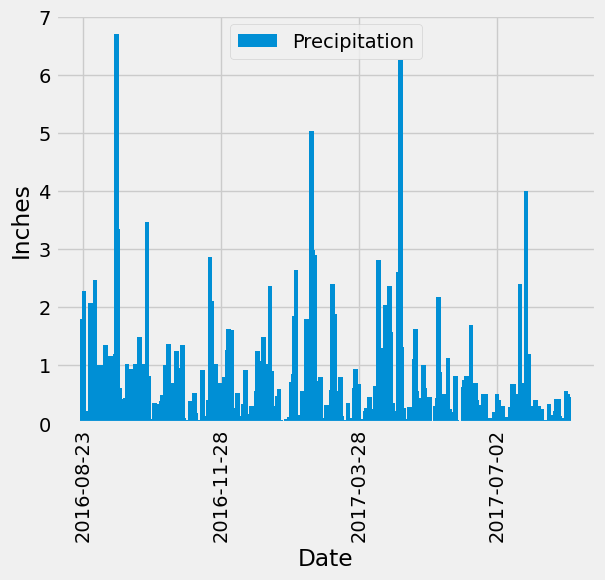

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
# Convert the Date Column to datetime

dates = np.array(max_precip_df['Date'])

#max_precip_df.plot.bar()
plt.bar(max_precip_df['Date'],max_precip_df['Precipitation'], width=3)
plt.tight_layout()
plt.ylabel('Inches')
plt.xlabel('Date')
plt.legend(["Precipitation"], loc="upper center")

plt.xticks(dates[::90], rotation=90)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = pd.DataFrame(prcp_df['Precipitation'].describe())
summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.name)).all()

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

stations = session.query(measurement.station, func.count(measurement.station)).\
            group_by(measurement.station).\
            order_by(func.count(measurement.station).desc()).all()
stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
            filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

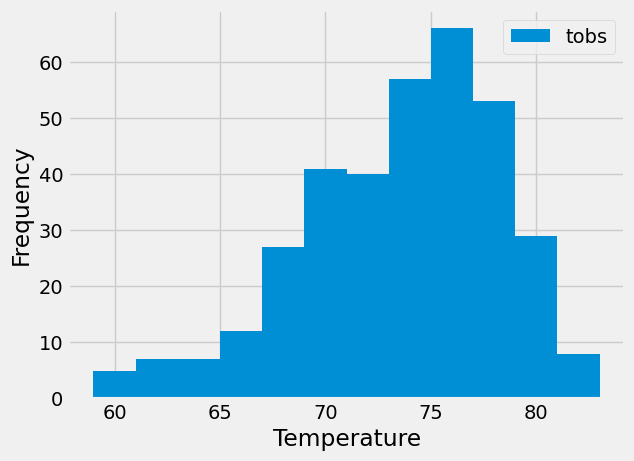

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs).\
            filter(measurement.station == 'USC00519281').filter(measurement.date > query_date).all()

# Save as Pandas_df
temps = pd.DataFrame(tobs_data)

            
# Plot
plt.hist(temps, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(["tobs"], loc= 'upper right')
plt.show()

# Close Session

In [17]:
# Close Session
session.close()